# Import libraries

In [2]:
import os
import sys
import pypots
import numpy as np
import benchpots
import matplotlib.pyplot as plt
from pypots.optim import Adam
from pypots.imputation import SAITS, BRITS, USGAN, GPVAE, MRNN
from pypots.utils.random import set_random_seed
from functions.toolkits import toolkits
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from MAEModify.error import calc_mae


2025-05-05 20:24:39.259357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746487479.274865   14442 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746487479.279775   14442 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 20:24:39.296210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidge


████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



# Load Dataset

In [3]:
set_random_seed()
physionet2012_dataset = benchpots.datasets.preprocess_physionet2012(subset="all", rate=0.1)
print(physionet2012_dataset.keys())

2025-05-05 20:24:42 [INFO]: Have set the random seed as 2022 for numpy and pytorch.
2025-05-05 20:24:42 [INFO]: You're using dataset physionet_2012, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/physionet_2012
2025-05-05 20:24:42 [INFO]: Dataset physionet_2012 has already been downloaded. Processing directly...
2025-05-05 20:24:42 [INFO]: Dataset physionet_2012 has already been cached. Loading from cache directly...
2025-05-05 20:24:42 [INFO]: Loaded successfully!
2025-05-05 20:24:55 [WARNING]: Note that physionet_2012 has sparse observations in the time series, hence we don't add additional missing values to the training dataset. 
2025-05-05 20:24:55 [INFO]: 68807 values masked out in the val set as ground truth, take 9.97% of the original observed values
2025-05-05 20:24:55 [INFO]: 86319 values masked out in the test set as ground truth, take 9.99% of the original observed v

dict_keys(['n_classes', 'n_steps', 'n_features', 'scaler', 'train_X', 'train_y', 'train_ICUType', 'val_X', 'val_y', 'val_ICUType', 'test_X', 'test_y', 'test_ICUType', 'val_X_ori', 'test_X_ori'])


In [4]:
dataset_for_training = {
    "X": physionet2012_dataset['train_X'],
}

dataset_for_validating = {
    "X": physionet2012_dataset['val_X'],
    "X_ori": physionet2012_dataset['val_X_ori'],
}

dataset_for_testing = {
    "X": physionet2012_dataset['test_X'],
}

test_X_indicating_mask = np.isnan(physionet2012_dataset['test_X_ori']) ^ np.isnan(physionet2012_dataset['test_X'])
test_X_ori = np.nan_to_num(physionet2012_dataset['test_X_ori']) 

# Train/Load Models

## SAITS

In [5]:
saits = SAITS(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_layers=1,
    d_model=256,
    d_ffn=128,
    n_heads=4,
    d_k=64,
    d_v=64,
    dropout=0.1,
    ORT_weight=1,  
    MIT_weight=1,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-05 20:25:00 [INFO]: No given device, using default device: cuda
2025-05-05 20:25:00 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-05 20:25:00 [INFO]: Using customized MAE as the training loss function.
2025-05-05 20:25:00 [INFO]: Using customized MSE as the validation metric function.
2025-05-05 20:25:00 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 720,182


In [6]:
saits.load("../mae/tutorial_results/imputation/saits/20250422_T181642/SAITS.pypots")

2025-05-05 20:25:00 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/saits/20250422_T181642/SAITS.pypots


## BRITS

In [7]:
brits = BRITS(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=128,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-05 20:25:00 [INFO]: No given device, using default device: cuda
2025-05-05 20:25:00 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-05 20:25:00 [INFO]: Using customized MAE as the training loss function.
2025-05-05 20:25:00 [INFO]: Using customized MSE as the validation metric function.
2025-05-05 20:25:00 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 239,344


In [8]:
brits.load("../mae/tutorial_results/imputation/brits/20250422_T181643/BRITS.pypots")

2025-05-05 20:25:00 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/brits/20250422_T181643/BRITS.pypots


## USGAN

In [9]:
us_gan = USGAN(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=256,
    lambda_mse=1,
    dropout=0.1,
    G_steps=1,
    D_steps=1,
    batch_size=32,
    epochs=10,
    patience=3,
    G_optimizer=Adam(lr=1e-3),
    D_optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-05 20:25:00 [INFO]: No given device, using default device: cuda
2025-05-05 20:25:00 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-05 20:25:00 [INFO]: USGAN initialized with the given hyperparameters, the number of trainable parameters: 1,258,517


In [10]:
us_gan.load("../mae/tutorial_results/imputation/us_gan/20250422_T181643/USGAN.pypots")

2025-05-05 20:25:00 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/us_gan/20250422_T181643/USGAN.pypots


## GP-VAE

In [11]:
gp_vae = GPVAE(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    latent_size=37,
    encoder_sizes=(128,128),
    decoder_sizes=(256,256),
    kernel="cauchy",
    beta=0.2,
    M=1,
    K=1,
    sigma=1.005,
    length_scale=7.0,
    kernel_scales=1,
    window_size=24,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-05 20:25:00 [INFO]: No given device, using default device: cuda
2025-05-05 20:25:00 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-05 20:25:00 [INFO]: GPVAE initialized with the given hyperparameters, the number of trainable parameters: 229,652


In [12]:
gp_vae.load("../mae/tutorial_results/imputation/gp_vae/20250422_T181643/GPVAE.pypots")

2025-05-05 20:25:00 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/gp_vae/20250422_T181643/GPVAE.pypots


## MRNN

In [13]:
mrnn = MRNN(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=128,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device=None,
    model_saving_strategy="best",
)

2025-05-05 20:25:00 [INFO]: No given device, using default device: cuda
2025-05-05 20:25:00 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-05-05 20:25:00 [INFO]: Using customized RMSE as the training loss function.
2025-05-05 20:25:00 [INFO]: Using customized MSE as the validation metric function.
2025-05-05 20:25:00 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 107,951


In [14]:
mrnn.load("../mae/tutorial_results/imputation/mrnn/20250422_T181643/MRNN.pypots")

2025-05-05 20:25:00 [INFO]: Model loaded successfully from ../mae/tutorial_results/imputation/mrnn/20250422_T181643/MRNN.pypots


# Imputation models

## SAITS

In [15]:
saits_results = saits.predict(dataset_for_testing)
saits_imputation = saits_results["imputation"]

## BRITS

In [16]:
brits_results = brits.predict(dataset_for_testing)
brits_imputation = brits_results["imputation"]

## US-GAN

In [17]:
us_gan_results = us_gan.predict(dataset_for_testing)
us_gan_imputation = us_gan_results["imputation"]

## GP-VAE

In [18]:
gp_vae_results = gp_vae.predict(dataset_for_testing)
gp_vae_imputation = gp_vae_results["imputation"]

## MRNN

In [19]:
mrnn_results = mrnn.predict(dataset_for_testing)
mrnn_imputation = mrnn_results["imputation"]

# AE/MAE Models

## SAITS

In [20]:
saits_mae, saits_ae = calc_mae(
    saits_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

## BRITS

In [21]:
brits_mae, brits_ae = calc_mae(
    brits_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

## US-GAN

In [22]:
usgan_mae, usgan_ae = calc_mae(
    us_gan_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

## GP-VAE

In [23]:
gp_vae_imputation = np.squeeze(gp_vae_imputation, axis=1)

gpvae_mae, gpvae_ae = calc_mae(
    gp_vae_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

## MRNN

In [24]:
mrnn_mae, mrnn_ae = calc_mae(
    mrnn_imputation,
    test_X_ori,
    test_X_indicating_mask,
)

# Gini Models

## SAITS

In [25]:
test_X_indicating_mask = test_X_indicating_mask.reshape(len(test_X_indicating_mask) * 48 * 37)
saits_ae = saits_ae.reshape(len(saits_ae) * 48 * 37)

In [26]:
saits_ae_mask = []

for i in range(len(test_X_indicating_mask)):
    if(test_X_indicating_mask[i] == True):
        saits_ae_mask.append(saits_ae[i])

saits_ae_mask = np.array(saits_ae_mask)

In [27]:
saits_gini = toolkits.gini(saits_ae_mask)
saits_gini

np.float64(0.6156662705330658)

## BRITS

In [28]:
brits_ae = brits_ae.reshape(len(brits_ae) * 48 * 37)

In [29]:
brits_ae_mask = []

for i in range(len(test_X_indicating_mask)):
    if(test_X_indicating_mask[i] == True):
        brits_ae_mask.append(brits_ae[i])

brits_ae_mask = np.array(brits_ae_mask)

In [30]:
brits_gini = toolkits.gini(brits_ae_mask)
brits_gini

np.float64(0.6372775398049433)

## USGAN

In [31]:
usgan_ae = usgan_ae.reshape(len(usgan_ae) * 48 * 37)

In [32]:
usgan_ae_mask = []

for i in range(len(test_X_indicating_mask)):
    if(test_X_indicating_mask[i] == True):
        usgan_ae_mask.append(usgan_ae[i])

usgan_ae_mask = np.array(usgan_ae_mask)

In [33]:
usgan_gini = toolkits.gini(usgan_ae_mask)
usgan_gini

np.float64(0.5760994066946155)

## GP-VAE

In [34]:
gpvae_ae = gpvae_ae.reshape(len(gpvae_ae)*48*37)

In [35]:
gpvae_ae_mask = []

for i in range(len(test_X_indicating_mask)):
    if(test_X_indicating_mask[i] == True):
        gpvae_ae_mask.append(gpvae_ae[i])

gpvae_ae_mask = np.array(gpvae_ae_mask)

In [36]:

gpvae_gini = toolkits.gini(gpvae_ae_mask)
gpvae_gini

np.float64(0.5071784128655386)

## MRNN

In [37]:
mrnn_ae = mrnn_ae.reshape(len(mrnn_ae)*48*37)

In [38]:
mrnn_ae_mask = []

for i in range(len(test_X_indicating_mask)):
    if(test_X_indicating_mask[i] == True):
        mrnn_ae_mask.append(mrnn_ae[i])

mrnn_ae_mask = np.array(mrnn_ae_mask)

In [39]:
mrnn_gini = toolkits.gini(mrnn_ae_mask)
mrnn_gini

np.float64(0.4394369928414541)

# Lorenz Curve

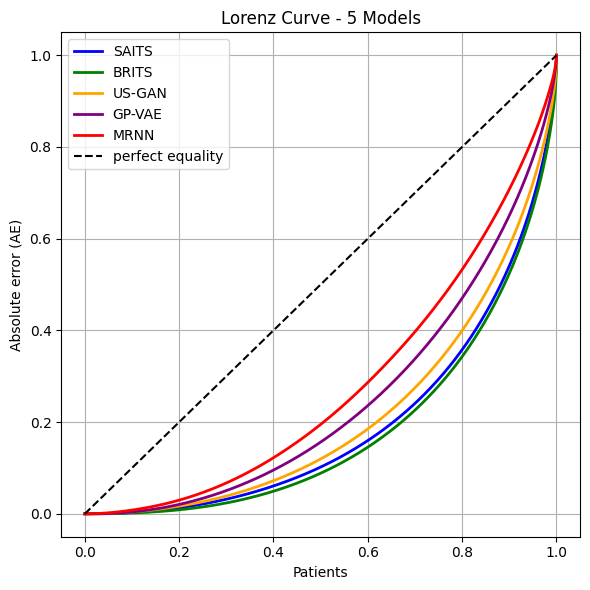

In [40]:
toolkits.lorenz_curve_5(saits_ae_mask, brits_ae_mask, usgan_ae_mask, gpvae_ae_mask, mrnn_ae_mask)